<a href="https://colab.research.google.com/github/xazhu9/AIPI-590/blob/main/Assignment%206/Assignment%206.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AIPI 590 - XAI | Assignment #06

Xuanang Zhu

Description: Fit Insurance Charges into Random Forest and produce PDP, ICE, and ALE plots

https://github.com/xazhu9/AIPI-590/blob/main/Assignment%206/Assignment%206.ipynb


In [1]:
pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-mcon_5n6/alepython_cd15f95e277e4a9c81cfe3cc37f61b75
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-mcon_5n6/alepython_cd15f95e277e4a9c81cfe3cc37f61b75
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
from alepython import ale_plot

Processing data, data convertion assisted by ChatGPT

In [3]:
# Load dataset
data = pd.read_csv('insurance.csv')

# Convert categorical features to numerical encoding
data['sex'] = data['sex'].map({'male': 0, 'female': 1})
data['smoker'] = data['smoker'].map({'yes': 1, 'no': 0})
data = pd.get_dummies(data, columns=['region'], drop_first=True)


EDA

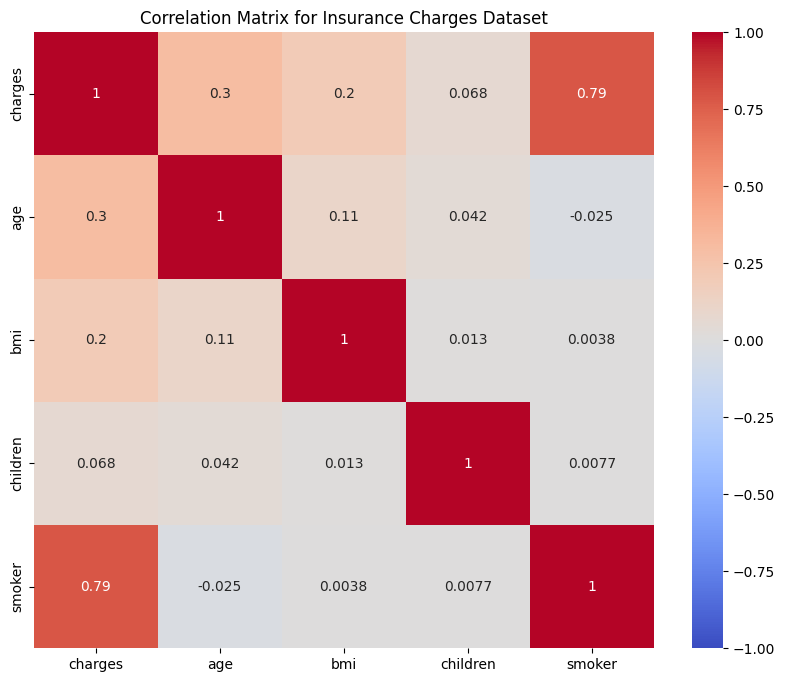

In [4]:
# Calculate the correlation matrix
corr_matrix = data[['charges', 'age', 'bmi', 'children', 'smoker']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Insurance Charges Dataset')
plt.show()


Random Forest model training

In [5]:
# Split data into features and target
X = data.drop('charges', axis=1)
y = data['charges']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

Using age for plot

PDP Plot

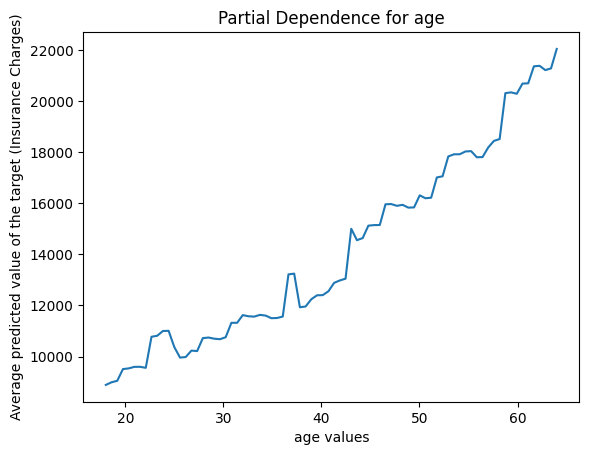

In [9]:
# Get the feature index and name
feature_index = X.columns.get_loc('age')  # Select age
feature_name = X.columns[feature_index]

# Generate a grid of values for the feature
feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=80)

# Initialize an array to store the average prediction for each feature value
average_predictions = np.zeros_like(feature_values)

# Create a copy
X_modified = X.copy()
X_modified[feature_name] = X_modified[feature_name].astype(float)  # Ensure the feature column is float type

# Iterate over the feature values in the grid
for i, value in enumerate(feature_values):
    # Replace all values of the selected feature with the current value in the grid
    X_modified.iloc[:, feature_index] = value

    # Predict
    predictions = model.predict(X_modified)

    # Calculate the average prediction
    average_predictions[i] = np.mean(predictions)

# Plot
plt.plot(feature_values, average_predictions)
plt.xlabel(f'{feature_name} values')  # Use the feature name as the label for the X
plt.ylabel('Average predicted value of the target (Insurance Charges)')
plt.title(f'Partial Dependence for {feature_name}')  # Use the feature name as the plot title
plt.show()



This PDP plot shows the effect of age on predicted insurance charges. As age increases, the average predicted insurance cost rises, indicating a positive relationship between age and insurance charges. This trend suggests that older individuals generally face higher insurance costs, likely due to increased health risks associated with aging.

The curve steepens significantly after around age 40, reflecting a stronger impact of age on charges in middle to older age groups.

ICE plot

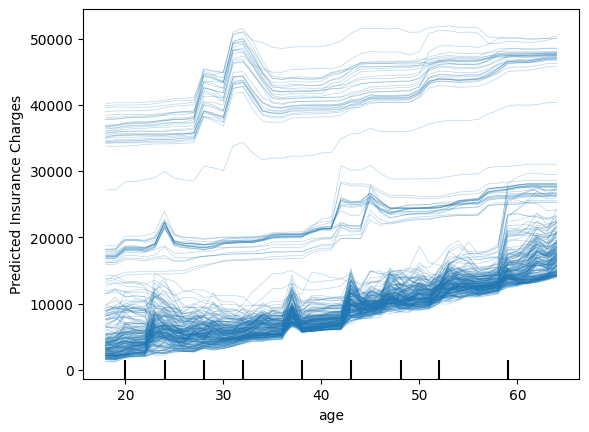

In [7]:
# Use 'age' as the feature
features = ["age"]

# Generate the ICE plot
display = PartialDependenceDisplay.from_estimator(model, X_test, features, kind='individual')

# Change the Y-axis label to "Predicted Insurance Charges"
display.axes_[0, 0].set_ylabel("Predicted Insurance Charges")

# Show the plot
plt.show()



This ICE plot shows the effect of age on predicted insurance charges for individual samples. The general pattern is that higher age leads to higher charges. The plot reveals a distinct separation between two groups, likely due to the smoker status, where smokers have much higher predicted charges than non-smokers base on the correlation matrix, creating a clear gap. This separation highlights the impact of categorical features like smoking on insurance charges, leading to a layered structure in the predictions.

Unlike the PDP, which displays the overall average effect of age and smooths out these differences, the ICE plot preserves individual sample paths, making it clear how age affects different subgroups uniquely, especially between smokers and non-smokers.

ALE plots

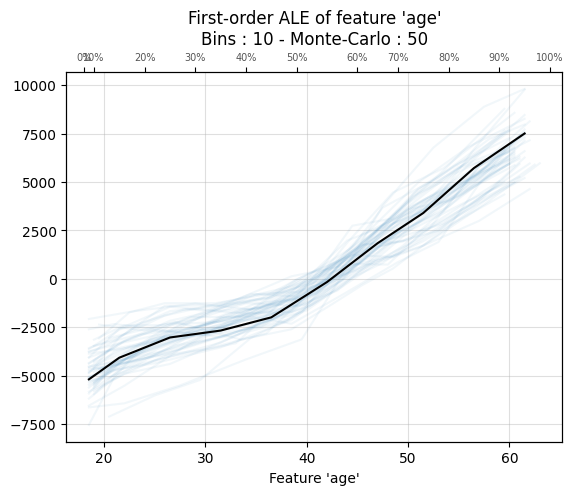

<Axes: title={'center': "First-order ALE of feature 'age'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'age'">

In [8]:
ale_plot(model, X_train, 'age', monte_carlo=True)

This ALE plot shows the local effect of age on predicted insurance charges. As age increases, the ALE curve gradually rises, indicating a positive relationship between age and insurance costs.

Compared to the PDP, the ALE plot is smoother and captures a more gradual increase, especially at younger ages, reflecting a more realistic effect of age across different intervals. Unlike the PDP, the ALE plot accounts for feature correlations, making it a more accurate representation of age’s true impact on charges by reducing the influence of interactions with other factors, such as smoker status.

Based on the correlation matrix, the smoker feature has a strong positive correlation (0.79) with charges (insurance cost), indicating that smoking status is a major factor contributing to higher predicted insurance charges, which aligns with the trends observed in the plots. Additionally, age shows a moderate correlation (0.3) with charges, suggesting that age also plays a significant but more moderate role in predicting insurance costs. The relatively low correlations between age, bmi, and children indicate that these features are mostly independent of each other, reducing concerns about multicollinearity.

However, the high correlation between smoker and charges might create bias in interpretation, particularly in PDP plots, as the strong influence of smoking could overshadow the effects of other features, potentially distorting the overall view of how individual features like age impact insurance costs. In this case, focusing separately on age and smoker in the analysis helps provide a more nuanced understanding of their respective impacts on insurance charges.